In [1]:
# 1 import library
import dis
import imageio
import matplotlib
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchvision.utils import make_grid, save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms

matplotlib.style.use('ggplot')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [2]:
# 2 variable setting
batch_size = 512
epochs = 200
sample_size = 64
nz = 128
k = 1

In [3]:
# 3 mnist download
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
train_dataset = datasets.MNIST(
    root="data2", train=True, transform=transform, download=True
)
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

In [4]:
# 4 Generator
class Generator(nn.Module):
    def __init__(self, nz):
        super().__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

In [5]:
# 5 Descriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [6]:
# 6 object setting
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print(generator)
print(discriminator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [7]:
# 7 loss function, optimizer setting
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

losses_g = []
losses_d = []
images = []

In [8]:
# 8 image save function
def save_generator_image(image, path):
    save_image(image, path)

In [9]:
# 9 descriminator train function
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = torch.ones(b_size, 1).to(device)
    fake_label = torch.zeros(b_size, 1).to(device)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [10]:
# 10 generator train function
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = torch.ones(b_size, 1).to(device)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [ ]:
# 11 model training
generator.train()
discriminator.train()

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    idxh = 0
    for idx, data in enumerate(train_loader):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        for step in range(k):
            data_fake = generator(torch.randn(b_size, nz).to(device).detach())
            data_real = image
            loss_d += train_discriminator(optim_d, image, data_fake)
        data_fake = generator(torch.randn(b_size, nz).to(device).detach())
        loss_g += train_generator(optim_g, data_fake)
        idxh = idx

    generated_image = generator(torch.randn(sample_size, nz).to(device)).cpu().detach()
    generated_image = make_grid(generated_image)
    save_generator_image(generated_image, f"data2/generated_images_{epoch}.png")
    images.append(generated_image)
    epoch_loss_g = loss_g / idxh
    epoch_loss_d = loss_d / idxh
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

Epoch 0 of 200
Generator loss: 1.34530079, Discriminator loss: 0.91263080
Epoch 1 of 200
Generator loss: 2.15923691, Discriminator loss: 1.21483958


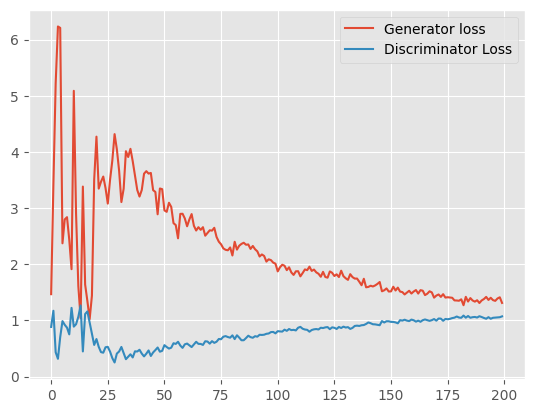

In [ ]:
# 12 pltting
plt.figure()
losses_g = [fl.item() for fl in losses_g]
plt.plot(losses_g, label="Generator loss")
losses_d = [fl.item() for fl in losses_d]
plt.plot(losses_d, label="Discriminator Loss")
plt.legend()
plt.show()

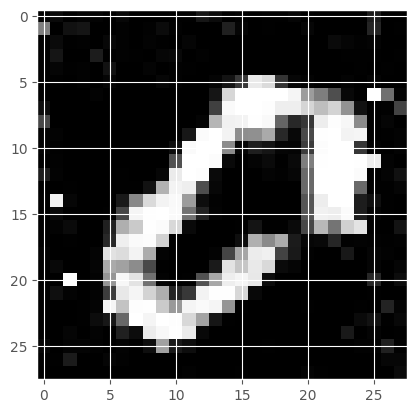

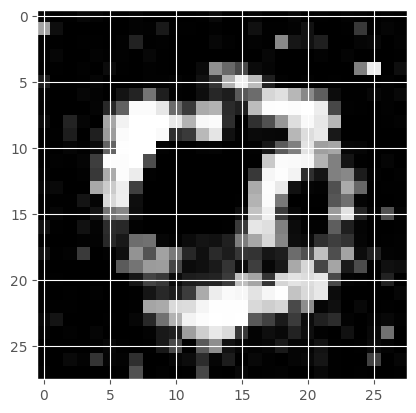

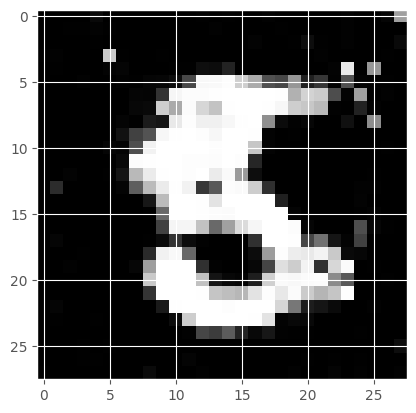

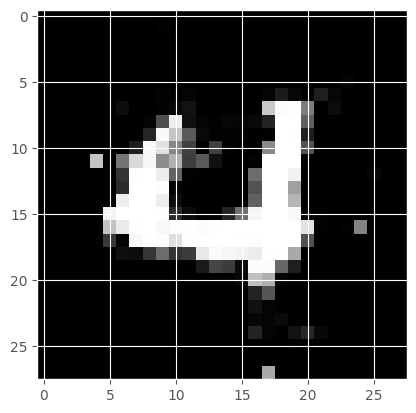

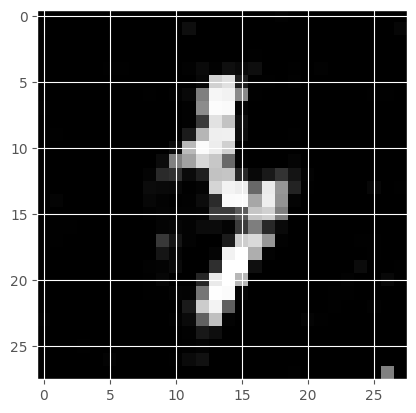

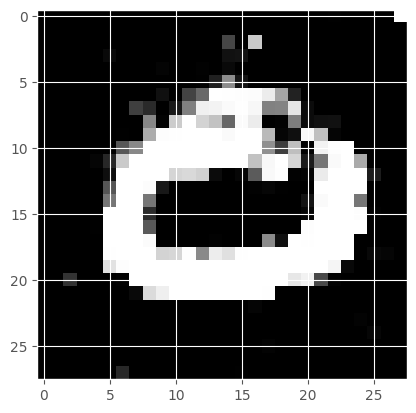

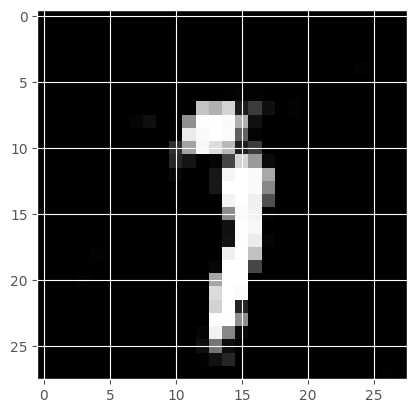

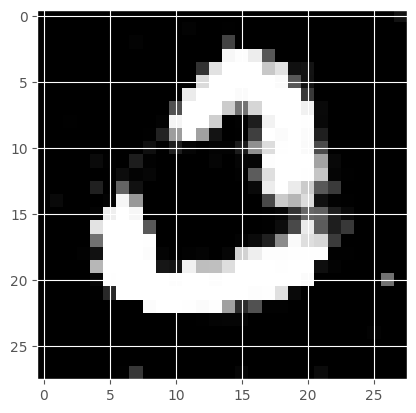

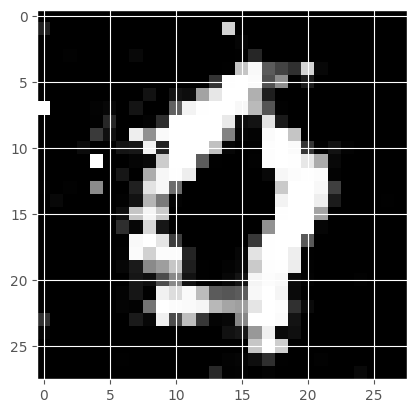

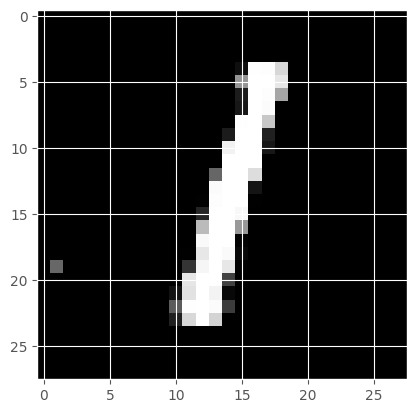

In [ ]:
# 13 image gereration
import numpy as np

fake_images = generator(torch.randn(batch_size, nz).to(device))
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().detach().numpy()[i], (28, 28))
    plt.imshow(fake_images_img, cmap="gray")
    # plt.savefig(f"pytorch/data2/fake_images_img_{i}.png")
    plt.show()

In [ ]:
# 1 라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image
from tqdm import tqdm
import numpy as np

plt.style.use("ggplot")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# 2 변수 설정
batch_size = 512
epochs = 200
sample_size = 64
nz = 128  # 노이즈 벡터 크기
num_classes = 10  # MNIST 숫자 클래스 (0~9)
k = 2

In [ ]:
# 3 MNIST 데이터셋 다운로드
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
train_dataset = datasets.MNIST(
    root="pytorch/data2", train=True, transform=transform, download=True
)
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 54.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.69MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.84MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# 4 생성자 (Conditional GAN)
class Generator(nn.Module):
    def __init__(self, nz, num_classes):
        super().__init__()
        self.nz = nz
        self.num_classes = num_classes
        # 레이블 임베딩
        self.label_emb = nn.Embedding(num_classes, num_classes)
        # 생성자 입력: 노이즈 + 레이블
        self.main = nn.Sequential(
            nn.Linear(self.nz + num_classes, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x, labels):
        # 레이블을 임베딩하고 노이즈와 결합
        label_emb = self.label_emb(labels)
        x = torch.cat([x, label_emb], dim=1)
        return self.main(x).view(-1, 1, 28, 28)

In [ ]:
# 5 판별자 (Conditional GAN)
class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.n_input = 784
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.main = nn.Sequential(
            nn.Linear(self.n_input + num_classes, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, labels):
        x = x.view(-1, 784)
        label_emb = self.label_emb(labels)
        x = torch.cat([x, label_emb], dim=1)
        return self.main(x)

In [ ]:
# 6 객체 설정
generator = Generator(nz, num_classes).to(device)
discriminator = Discriminator(num_classes).to(device)
print(generator)
print(discriminator)

Generator(
  (label_emb): Embedding(10, 10)
  (main): Sequential(
    (0): Linear(in_features=138, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (label_emb): Embedding(10, 10)
  (main): Sequential(
    (0): Linear(in_features=794, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias

In [ ]:
# 7 손실 함수 및 옵티마이저 설정
optim_g = optim.Adam(generator.parameters(), lr=0.0001)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0001)
criterion = nn.BCELoss()

losses_g = []
losses_d = []
images = []

In [ ]:
# 8 이미지 저장 함수
def save_generator_image(image, path):
    save_image(image, path)

In [ ]:
# 9 판별자 학습 함수
def train_discriminator(optimizer, data_real, labels, data_fake):
    b_size = data_real.size(0)
    real_label = torch.ones(b_size, 1).to(device)
    fake_label = torch.zeros(b_size, 1).to(device)
    optimizer.zero_grad()
    output_real = discriminator(data_real, labels)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake, labels)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [ ]:
# 10 생성자 학습 함수
def train_generator(optimizer, data_fake, labels):
    b_size = data_fake.size(0)
    real_label = torch.ones(b_size, 1).to(device)
    optimizer.zero_grad()
    output = discriminator(data_fake, labels)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [ ]:
# 11 모델 학습
generator.train()
discriminator.train()

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    idxh = 0
    for idx, (image, labels) in enumerate(train_loader):
        image = image.to(device)
        labels = labels.to(device)
        b_size = len(image)
        for step in range(k):
            # 랜덤 노이즈와 동일한 레이블 사용
            data_fake = generator(torch.randn(b_size, nz).to(device), labels).detach()
            data_real = image
            loss_d += train_discriminator(optim_d, data_real, labels, data_fake)
        data_fake = generator(torch.randn(b_size, nz).to(device), labels).detach()
        loss_g += train_generator(optim_g, data_fake, labels)
        idxh = idx

    # 특정 숫자(예: 0~9 중 랜덤)로 샘플 이미지 생성
    sample_labels = torch.randint(0, num_classes, (sample_size,)).to(device)
    generated_image = generator(torch.randn(sample_size, nz).to(device), sample_labels).cpu().detach()
    generated_image = make_grid(generated_image)
    save_generator_image(generated_image, f"pytorch/data2/generated_images_{epoch}.png")
    images.append(generated_image)
    epoch_loss_g = loss_g / idxh
    epoch_loss_d = loss_d / idxh
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

Epoch 0 of 200
Generator loss: 22.73000908, Discriminator loss: 0.00000002
Epoch 1 of 200
Generator loss: 24.73885345, Discriminator loss: 0.00000000


KeyboardInterrupt: 

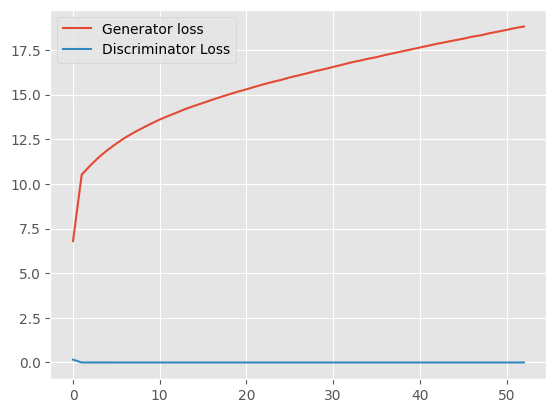

In [ ]:
# 12 손실 그래프
plt.figure()
losses_g = [fl.item() for fl in losses_g]
plt.plot(losses_g, label="Generator loss")
losses_d = [fl.item() for fl in losses_d]
plt.plot(losses_d, label="Discriminator Loss")
plt.legend()
plt.show()

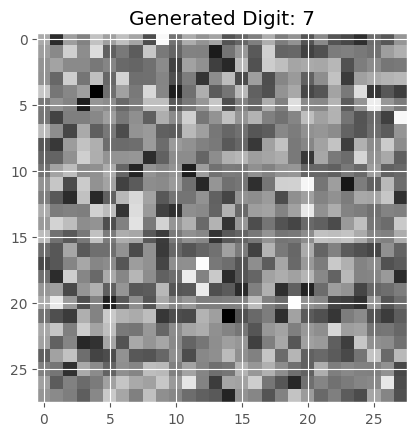

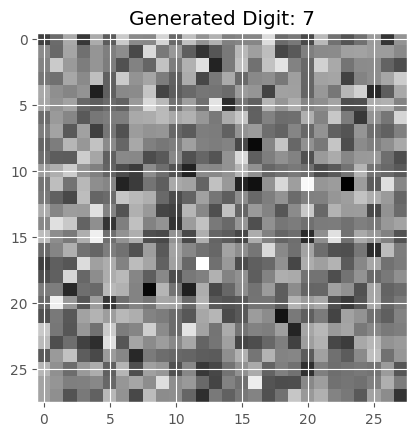

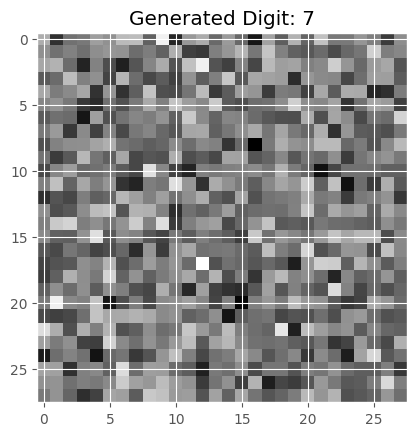

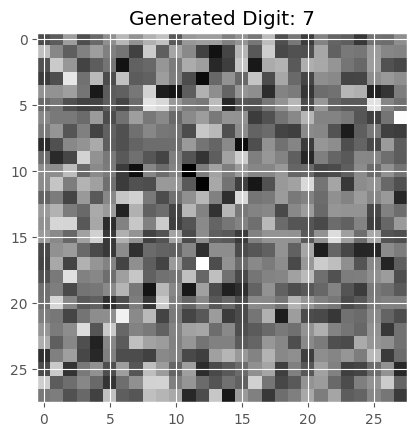

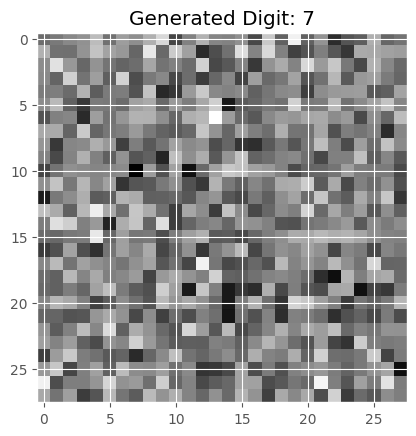

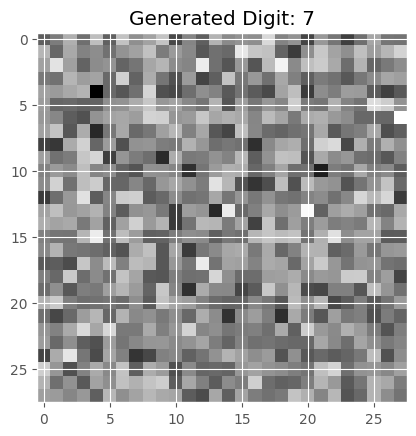

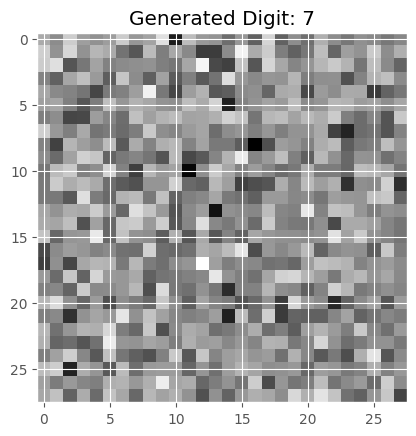

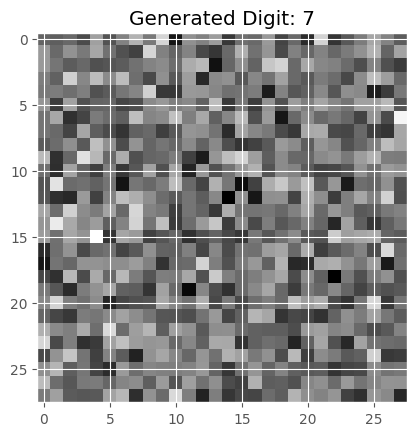

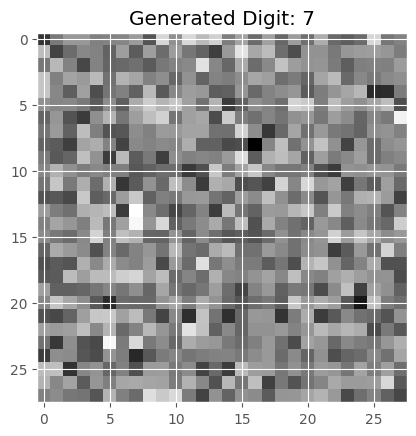

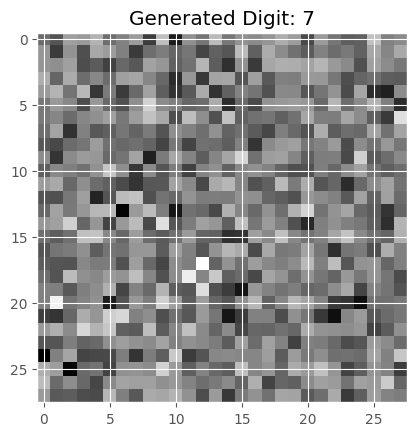

In [ ]:
# 13 특정 숫자 이미지 생성
desired_digit = 7  # 원하는 숫자 (예: 7)
num_samples = 10
noise = torch.randn(num_samples, nz).to(device)
labels = torch.full((num_samples,), desired_digit, dtype=torch.long).to(device)
fake_images = generator(noise, labels).cpu().detach()

for i in range(num_samples):
    fake_image = np.reshape(fake_images[i], (28, 28))
    plt.imshow(fake_image, cmap="gray")
    plt.title(f"Generated Digit: {desired_digit}")
    plt.savefig(f"pytorch/data2/fake_images_digit_{desired_digit}_{i}.png")
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image
import numpy as np

plt.style.use("ggplot")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# 1. 변수 설정
batch_size = 128
epochs = 200
sample_size = 64
nz = 100  # 노이즈 벡터 크기
num_classes = 10  # MNIST 숫자 클래스 (0~9)
k = 1  # 판별자 학습 스텝 수
image_size = 64  # 입력 이미지를 64x64로 리사이즈
nc = 1  # 채널 수 (MNIST는 흑백이므로 1)

In [ ]:
# 2. 데이터셋 로드
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST(
    root="pytorch/data2", train=True, transform=transform, download=True
)
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# 3. 생성자 (Conditional DCGAN)
class Generator(nn.Module):
    def __init__(self, nz, num_classes):
        super().__init__()
        self.nz = nz
        self.num_classes = num_classes
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.main = nn.Sequential(
            # 입력: [batch, nz + num_classes, 1, 1]
            nn.ConvTranspose2d(nz + num_classes, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 상태: [batch, 512, 4, 4]
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 상태: [batch, 256, 8, 8]
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 상태: [batch, 128, 16, 16]
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 상태: [batch, 64, 32, 32]
            nn.ConvTranspose2d(64, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # 출력: [batch, nc, 64, 64]
        )

    def forward(self, x, labels):
        # 레이블 임베딩과 노이즈 결합
        batch_size = x.size(0)
        label_emb = self.label_emb(labels).view(batch_size, self.num_classes, 1, 1)
        x = x.view(batch_size, self.nz, 1, 1)
        x = torch.cat([x, label_emb], dim=1)
        return self.main(x)

In [ ]:
# 4. 판별자 (Conditional DCGAN)
class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.main = nn.Sequential(
            # 입력: [batch, nc + num_classes, 64, 64]
            nn.Conv2d(nc + num_classes, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 상태: [batch, 64, 32, 32]
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 상태: [batch, 128, 16, 16]
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # 상태: [batch, 256, 8, 8]
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # 상태: [batch, 512, 4, 4]
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # 출력: [batch, 1, 1, 1]
        )

    def forward(self, x, labels):
        batch_size = x.size(0)
        label_emb = self.label_emb(labels).view(batch_size, self.num_classes, 1, 1)
        label_emb = label_emb.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat([x, label_emb], dim=1)
        return self.main(x).view(-1, 1)

In [ ]:
# 5. 객체 및 옵티마이저 설정
generator = Generator(nz, num_classes).to(device)
discriminator = Discriminator(num_classes).to(device)
print(generator)
print(discriminator)

optim_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

losses_g = []
losses_d = []
images = []

Generator(
  (label_emb): Embedding(10, 10)
  (main): Sequential(
    (0): ConvTranspose2d(110, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bi

In [ ]:
# 6. 이미지 저장 함수
def save_generator_image(image, path):
    save_image(image, path, normalize=True)

In [ ]:
# 7. 판별자 학습 함수
def train_discriminator(optimizer, data_real, labels, data_fake):
    b_size = data_real.size(0)
    real_label = torch.ones(b_size, 1).to(device)
    fake_label = torch.zeros(b_size, 1).to(device)
    optimizer.zero_grad()
    output_real = discriminator(data_real, labels)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake, labels)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [ ]:
# 8. 생성자 학습 함수
def train_generator(optimizer, data_fake, labels):
    b_size = data_fake.size(0)
    real_label = torch.ones(b_size, 1).to(device)
    optimizer.zero_grad()
    output = discriminator(data_fake, labels)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [ ]:
# 9. 모델 학습
generator.train()
discriminator.train()

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    idxh = 0
    for idx, (image, labels) in enumerate(train_loader):
        image = image.to(device)
        labels = labels.to(device)
        b_size = len(image)
        for step in range(k):
            data_fake = generator(torch.randn(b_size, nz).to(device), labels).detach()
            data_real = image
            loss_d += train_discriminator(optim_d, data_real, labels, data_fake)
        data_fake = generator(torch.randn(b_size, nz).to(device), labels)
        loss_g += train_generator(optim_g, data_fake, labels)
        idxh = idx + 1

    # 샘플 이미지 생성
    sample_labels = torch.randint(0, num_classes, (sample_size,)).to(device)
    generated_image = generator(torch.randn(sample_size, nz).to(device), sample_labels).cpu().detach()
    generated_image = make_grid(generated_image, nrow=8)
    save_generator_image(generated_image, f"pytorch/data2/dcgan_images_{epoch}.png")
    images.append(generated_image)
    epoch_loss_g = loss_g / idxh
    epoch_loss_d = loss_d / idxh
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [ ]:
# 10. 손실 그래프
plt.figure()
losses_g = [fl.item() for fl in losses_g]
plt.plot(losses_g, label="Generator loss")
losses_d = [fl.item() for fl in losses_d]
plt.plot(losses_d, label="Discriminator Loss")
plt.legend()
plt.savefig("pytorch/data2/dcgan_loss_plot.png")
plt.show()

In [ ]:
# 11. 특정 숫자 이미지 생성
desired_digit = 7  # 원하는 숫자 (예: 7)
num_samples = 10
noise = torch.randn(num_samples, nz).to(device)
labels = torch.full((num_samples,), desired_digit, dtype=torch.long).to(device)
fake_images = generator(noise, labels).cpu().detach()

for i in range(num_samples):
    fake_image = fake_images[i].squeeze().numpy()
    plt.imshow(fake_image, cmap="gray")
    plt.title(f"Generated Digit: {desired_digit}")
    plt.axis("off")
    plt.savefig(f"pytorch/data2/dcgan_digit_{desired_digit}_{i}.png")
    plt.show()